In [1]:
import sys
sys.path.append("../")
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import ssl
import urllib.request
import requests
import json
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import chain
from bids.modeling import BIDSStatsModelsGraph
from bids.layout import BIDSLayout, BIDSLayoutIndexer
from bids.tests import get_test_data_path
from os.path import join
from nilearn import image
from nilearn.interfaces.bids import parse_bids_filename
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, view_img
from scripts.utils import generate_tablecontents, get_bidstats_events, similarity_boldstand_metrics, get_low_quality_subs, pull_contrast_conditions_spec, eval_missing_events
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import json
import warnings
import matplotlib
import shutil
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)


In [80]:
generate_tablecontents("transformations.ipynb")

# Table of Contents

  - [ Dataset Description](#-Dataset-Description)
  - [ Brief Overview & Examples](#-Brief-Overview--Examples)
    - [ Dataset BIDS Layout](#-Dataset-BIDS-Layout)
    - [ Generic Spec File](#-Generic-Spec-File)
    - [ First-Level (Run-Level) GLM](#-First-Level-Run-Level-GLM)
      - [ Run-level Node](#-Run-level-Node)
        - [ Inspect Models](#-Inspect-Models)
          - [ **Plot Model Design Matrix**](#-Plot-Model-Design-Matrix)
          - [ **Plot Model's HRF**](#-Plot-Models-HRF)
    - [ Within-Subject Run Average / Differences (Subject-Level)](#-Within-Subject-Run-Average--Differences-Subject-Level)
      - [ Subject Level Node](#-Subject-Level-Node)
        - [ Inspect Models](#-Inspect-Models)
          - [ **Model Matrix**](#-Model-Matrix)
    - [ Group-Level](#-Group-Level)
      - [ Run 'dataset_level' node](#-Run-dataset_level-node)
          - [ **Plot Model Matrix**](#-Plot-Model-Matrix)
- [ Group Statistical Models](#-Group-Statistical-Models)
  - [ One Sample T-test](#-One-Sample-T-test)
    - [ Data Input](#-Data-Input)
    - [ Model Matrix](#-Model-Matrix)
  - [ One Sample T-test w/ Covariate](#-One-Sample-T-test-w-Covariate)
    - [ Data Input](#-Data-Input)
    - [ Model Matrix](#-Model-Matrix)
  - [ One Sample Paired T-test (runs) **[currently cannot fit]**](#-One-Sample-Paired-T-test-runs-currently-cannot-fit)
  - [ Two-sample T-test](#-Two-sample-T-test)
      - [ Data Input](#-Data-Input)
      - [ Model Matrix](#-Model-Matrix)
  - [ Two-sample T-test w/ Covariate](#-Two-sample-T-test-w-Covariate)
      - [ Data Input](#-Data-Input)
      - [ Model Matrix](#-Model-Matrix)
  - [ Two Group Continuous Interaction](#-Two-Group-Continuous-Interaction)
  - [2 + Group ANOVA](#2--Group-ANOVA)
      - [ Data Input](#-Data-Input)
      - [ Model Matrix](#-Model-Matrix)

## Dataset Description

In the below analyses, the focus in on the OpenNeuro dataset [ds000171](https://openneuro.org/datasets/ds000171/). This dataset was chosen for several reasons:

1. Available fMRIprep derivates computed and pushed to AWS S3 Bucket
2. Availability of task fMRI data (music and nonmusic)
3. Availability of two separate groups: Sex (M/F) and Group (Control, Major Depressive Disorder) that faciliates two-sample t-test
4. Availability of multiple runs that facilitates paired t-test for 2 runs.
5. Wide age-range (18-59) for (a) covariate analyses and (b) bining age groups for a 2+ group ANOVA.

In [4]:
study_id = 'ds000171'
taskname = "music"
# TR and num of volumes are determined by BIDS-SM dynamical, we hardcode one for simplicity here
TR = 3
volumes = 110
bids_inp = f"/oak/stanford/groups/russpold/data/openneuro_fitlins/input/{study_id}"

## Brief Overview & Examples

BIDS Stats Models (BIDS-SM) uses a model specification that includes nodes that contains the "instructions" for each step in the analyses. These instructions come with a different set of [ingestible data](https://bids-standard.github.io/stats-models/walkthrough-1.html) and [sets of transformations](https://docs.google.com/document/d/1uxN6vPWbC7ciAx2XWtT5Y-lBrdckZKpPdNUNpwRxHoU/edit?tab=t.0). As illustrated in the OpenNeuro GLM repository's [jupyter notebook](https://github.com/demidenm/openneuro_glmfitlins/tree/main/scripts/jupyter_notebooks) these transformations can very and had implications for run-, subject- and group-level model estimations. 

When performing the transformations, there are several key elements:

1. Which transformation are used and what is their purpose in the model estimatation a X node?
2. Did the transformation work?
3. What data are accessible at each node (e.g. run_level, subject_level, dataset_level)?
4. Most importantly, does the model *accuracy* represents that envisioned model and are there potential concerns?

We will use the BIDS-SM workflow to inspect the transformations and data accessible at each node:

1. Run-level: What is avaiable for the univariate/voxelwise *within run* models
2. Subject-level: What is avaiable for the univariate *within subject* models
3. Group-level: What is avaiable for the univariate *between subject* models

### Dataset BIDS Layout

Here we use BIDSLayout to obtain the layout for the dataset, compute the number of subjects, number of events files and total run numbers for the task. Since `<>.get_runs` simply returns the maximum number of runs based on the run names (e.g., if subjects have labels 1,2 = 2 runs, if labels 1 & 2 or 3 = 3 runs). We check in the table that each subject has a consistent number of runs and what the numbers are (helpful in spec / filtering if meaningful different)

In [33]:
bids_layout = BIDSLayout(bids_inp,derivatives=False)
events = bids_layout.get(task=taskname, suffix="events", extension=".tsv")
n_subjects = bids_layout.get_subjects(task=taskname)

print("N Subjects:", 
len(n_subjects), "N events files:", len(events), "for task name", taskname.upper(), "across N maximum runs:", len(bids_layout.get_runs(task=taskname)))

N Subjects: 39 N events files: 117 for task name MUSIC across N maximum runs: 5


In [52]:
subjects = bids_layout.get_subjects(task=taskname)
subject_data = []

for subject in subjects:
    # Get runs for this specific subject and task
    subject_runs = bids_layout.get_runs(subject=subject, task=taskname)
    subject_data.append({
        'Subject': f'sub-{subject}',
        'num_runs': len(subject_runs),
        'run_numbers': ', '.join(map(str, sorted(subject_runs)))
    })
df = pd.DataFrame(subject_data)

df.head(5)

,Subject,num_runs,run_numbers
0,sub-control01,3,"1, 2, 3"
1,sub-control02,3,"1, 2, 3"
2,sub-control03,3,"3, 4, 5"
3,sub-control04,3,"3, 4, 5"
4,sub-control05,3,"3, 4, 5"


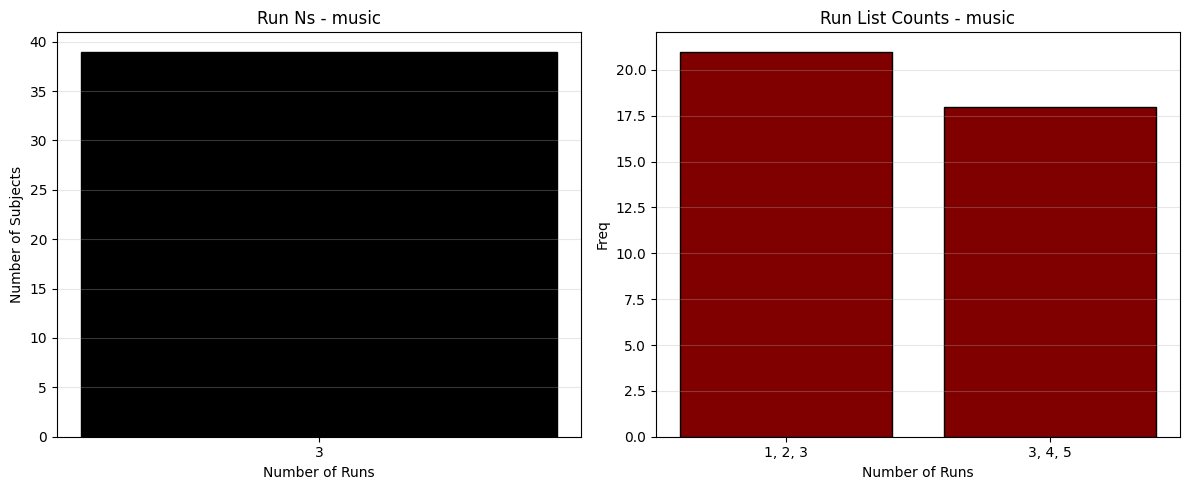

In [53]:
run_counts = df['num_runs'].value_counts().sort_index()
run_lists = df['run_numbers'].value_counts().sort_index()

# bar graph for number of runs per subject, a count of listed runs per sub
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(run_counts.index, run_counts.values, color='black', edgecolor='black')
ax1.set_xlabel('Number of Runs')
ax1.set_ylabel('Number of Subjects')
ax1.set_title(f'Run Ns - {taskname}')
ax1.set_xticks(run_counts.index)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(run_lists.index, run_lists.values, color='maroon', edgecolor='black')
ax2.set_xlabel('Number of Runs')
ax2.set_ylabel('Freq')
ax2.set_title(f'Run List Counts - {taskname}')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Generic Spec File

Setting up a generic spec file to get the BIDS model information. The below is a simple specification file for a one-sample t-test. We will run this with the ```get_bidstats_events()``` function to get a graph of the model. 

In [176]:
gen_spec = {
  "Name": "ds000171",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "control01",
      "control02",
      "control03",
      "control04",
      "control05",
      "control06",
      "control07",
      "control08",
      "control09",
      "control10",
      "control11",
      "control12",
      "control13",
      "control14",
      "control15",
      "control16",
      "control17",
      "control18",
      "control19",
      "control20",
      "mdd01",
      "mdd02",
      "mdd03",
      "mdd04",
      "mdd05",
      "mdd06",
      "mdd07",
      "mdd08",
      "mdd09",
      "mdd10",
      "mdd11",
      "mdd12",
      "mdd13",
      "mdd14",
      "mdd15",
      "mdd16",
      "mdd17",
      "mdd18",
      "mdd19"
    ],
    "task": [
      "music"
    ],
    "run": [
      1,
      2,
      3,
      4,
      5
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*",
          "rot_*",
          "cosine*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "musicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            0.5,
            0.5,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvnegmusic",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusicvsounds",
          "ConditionList": [
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusic",
          "ConditionList": [
            "trial_type.positive_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusic",
          "ConditionList": [
            "trial_type.negative_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "tones",
          "ConditionList": [
            "trial_type.tones"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "response",
          "ConditionList": [
            "trial_type.response"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        }
      ]
    },
    {
      "Level": "Subject",
      "Name": "subject_level",
      "GroupBy": [
        "subject",
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    },
    {
      "Level": "Dataset",
      "Name": "data_level", 
      "GroupBy": [
        "contrast"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "group"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "group.*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "control_vs_mdd",
          "ConditionList": [
            "group.control",
            "group.mdd"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "mdd_vs_control", 
          "ConditionList": [
            "group.control",
            "group.mdd"
          ],
          "Weights": [
            -1,
            1
          ],
          "Test": "t"
        }
      ]
    }
  ]
}

_, _, graph = get_bidstats_events(bids_inp, gen_spec, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

### First-Level (Run-Level) GLM

This is the core model applied to the BOLD time-series data for each individual run. It is estimated at every voxel $v$ in the brain. This is what is estimated in the 'run_level' node.

$$Y_v = X\beta_v + \varepsilon_v$$

- $Y_v$: The vector of BOLD signal measurements over time at a single voxel $v$
- $X$: The **Design Matrix**. Each column is a regressor representing a hypothesized source of variance in the BOLD signal. This includes:
  - Task regressors (convolved with a hemodynamic response function)
  - Nuisance regressors (e.g., motion parameters, physiological noise)
  - Intercept (column of ones). The model's baseline (or mean signal, when all other regressors are zero) at the voxel, ensuring that the other regressors explain deviations *from* this baseline
- $\beta_v$: The vector of parameter estimates (beta weights) at voxel $v$. Each beta corresponds to the amplitude of the effect of one regressor in the design matrix (impacted by timing of events, convolution, and collinearity)
- $\varepsilon_v$: The vector of residual error (unexplained variance) at voxel $v$ over time

Can compute from the model: **contrast images** for each run. Simply a linear combination of beta weights that tests a specific hypothesis (e.g., `Task A > Task B`). Often good to compute VIFs for regressors and contrasts (e.g. tVIF and cVIF from [Mumford](https://github.com/jmumford/vif_contrasts))

#### Run-level Node 

We will now get and run the `run_level` node in order to look into the variables and transations at this node. This is what fitlins will run and prepare to pass downstream. The run level node name is derived from the field/key, which is within the spec file we specified above:

```python
...
"Name": "run_level",
...
```

In [177]:
# root node for basic details
run_level_node = graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

##### Inspect Models

In [122]:
print(f"Given our subject N ({len(n_subjects)}, 3 runs per), we expect a subject-by-run counts of run_level models: {len(run_specs)}.\nEach `run_level` model has a root plus N = {(len(run_specs[0].trans_hist)-1)} transformations.")

Given our subject N (39, 3 runs per), we expect a subject-by-run counts of run_level models: 117.
Each `run_level` model has a root plus N = 2 transformations.


We can inspect each of the transformations for each of the subject indices using:

```python
subject = 0 # first
trans_hist = 0 # input data before first applied
run_specs[subject].trans_hist[subject].output.to_df()
```


We can obtain the first ten rows. This shows us what is available for subject at index 0 (e.g. control01) for the first model (e.g. run1). It indicates the onset, duration, trial types and task label. This is what is available for manipulation in the next transformations 

**NOTE**: This will not include the information available in the *_confounds.tsv file as we are only getting layout of BIDS input files such as events.

In [123]:
subject = 0 # first
trans_hist = 0 # input data before first transformation applied
run_specs[subject].trans_hist[subject].output.to_df().head(10) # get first 10 rows

,onset,run,subject,duration,trial_type,suffix,task,datatype
0,0.0,1,control01,33.0,tones,bold,music,func
1,33.0,1,control01,3.0,response,bold,music,func
2,36.0,1,control01,31.5,negative_music,bold,music,func
3,67.5,1,control01,3.0,response,bold,music,func
4,70.5,1,control01,31.5,tones,bold,music,func
5,102.0,1,control01,3.0,response,bold,music,func
6,105.0,1,control01,31.5,positive_music,bold,music,func
7,136.5,1,control01,3.0,response,bold,music,func
8,139.5,1,control01,31.5,tones,bold,music,func
9,171.0,1,control01,3.0,response,bold,music,func


######  **Plot Model Design Matrix**


<Axes: label='conditions', ylabel='scan number'>

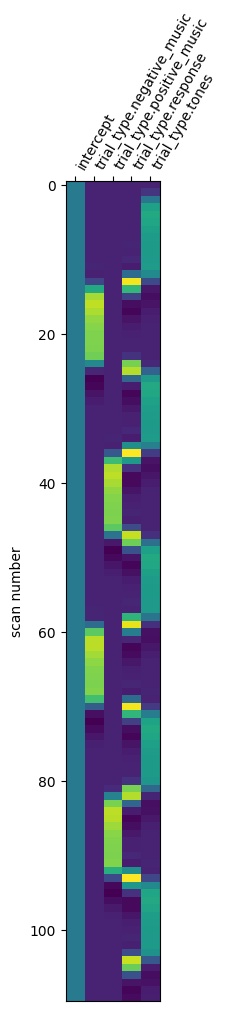

In [124]:
plot_design_matrix(run_specs[subject].X)

###### **Plot Model's HRF**

We can plot the HRF that will be regressed onto the brain data in the model: $$Y_v = X\beta_v + \varepsilon_v$$ (e.g., excluding nusiance regressors and intercept in this example)

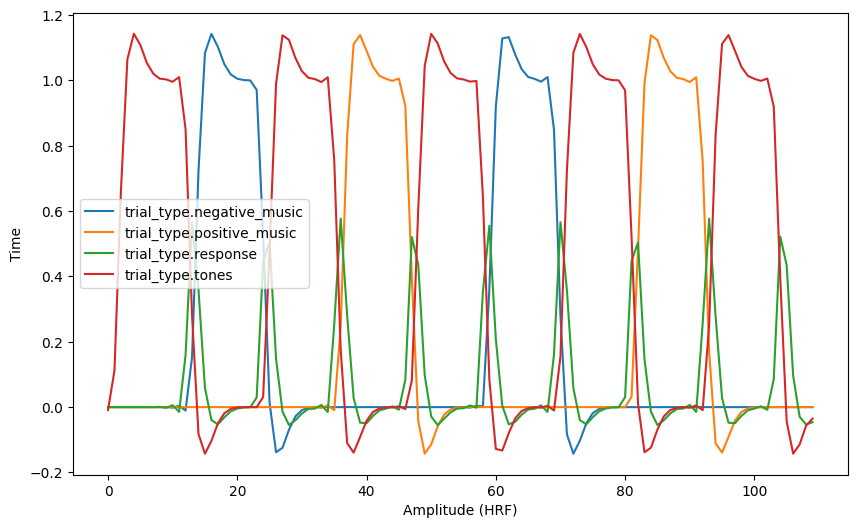

In [59]:
plt.figure(figsize=(10, 6))
data_to_plot = run_specs[subject].X

for i, col in enumerate(run_specs[subject].X.columns.difference(['intercept'])):
    plt.plot(data_to_plot[col], label=col)

plt.xlabel('Amplitude (HRF)')
plt.ylabel('Time')
plt.legend()
plt.show()

### Within-Subject Run Average / Differences (Subject-Level)

Estimates a single estimate of a task effect by averaging across multiple fMRI runs or taking a differences* of runs. Used in the group-level analysis. 


**a. Fixed-Effects Average**

Averages each contrast estimates across 1+ runs. *This is what can be estimated within the `Subject` node.*

Let $c_r(v)$ be the contrast value for run $r$ at voxel $v$. For a total of $R$ runs, the average contrast value is:

$$\bar{c}(v) = \frac{1}{R} \sum_{r=1}^{R} c_r(v)$$

- $\bar{c}(v)$: The average contrast value at voxel $v$
- $c_r(v)$: The contrast value from a single run $r$
- $R$: The total number of runs being averaged

**b. Within-Subject Paired Difference** *

Compare the effect of a condition between two runs (or two different conditions within the same run). This is often used to test for effects like learning, adaptation or fatigue.

Let $c_{\text{run1}}(v)$ and $c_{\text{run2}}(v)$ be the contrast values for the same task contrasts in Run 1 and Run 2. The difference is:

$$c_{\text{diff}}(v) = c_{\text{run2}}(v) - c_{\text{run1}}(v)$$

- $c_{\text{diff}}(v)$: The resulting difference value at voxel $v$. This difference image is then used in a group-level one-sample t-test to see if the difference is consistent across subjects (significantly positive or negative activity rejects the null, no activity differene)

> 
>  ***In the current version, we are unable to compute the within-subj run difference...**
> 


#### Subject Level Node

To run our subject level node, we will need some information to pass in from the `run_specs` for it to proceed. Here, we get the list of contrasts to achieve this.

In [178]:
# get contrasts from https://github.com/poldracklab/fitlins/blob/35f9a0d440731f3ad5630c56bda2780878885794/fitlins/utils/bids.py#L48
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = graph.get_node(name="subject_level")

subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

##### Inspect Models

The output from our run-level should be equivalent to the product of:
1. Number of subjects
2. Number of runs
3. Number of contrasts

In other words, we get a single output for each subject, run and contrast. At the subject_level, we can take the average *across* runs within a subject.

In [153]:
run_level_node = next(node for node in gen_spec['Nodes'] if node['Name'] == 'run_level')
contrast_names = [contrast['Name'] for contrast in run_level_node['Contrasts']]

In [154]:
print(f"Given our subject N ({len(n_subjects)}, 3 runs per) and N = {len(contrast_names)} contrast, \nwe expect a subject-by-run-by-contrast counts of models ran: {len(n_subjects)*3*len(contrast_names)}.")
print(f"\nThe resulting models at the subject level, since it is one per subject, is N = {len(subject_outputs)}")

Given our subject N (39, 3 runs per) and N = 8 contrast, 
we expect a subject-by-run-by-contrast counts of models ran: 936.

The resulting models at the subject level, since it is one per subject, is N = 312


Typically, the `subject_level` model may not need a transformation. So tere will not be a "transformation" key. In this case, one can look into the meta data that is present for a given subject. Below is the meta data and model (e.g. averaging beta maps within subject across runs)

In [156]:
subject_outputs[subject].metadata

,contrast,run,subject
0,musicvsounds,1,control01
1,musicvsounds,2,control01
2,musicvsounds,3,control01


######  **Model Matrix**


In [158]:
subject_outputs[subject].X

,intercept
0,1
1,1
2,1


### Group-Level 

This second-level model is used to make inferences about a population from the sample of subjects. In a one-sample t-test, the test whether the mean effect across all subjects is significantly different from zero (typically, two-sided). In a two-sample independent t-test, the test whether the mean effect between groups is significantly different from zero (two-sided). In a 2+ group ANOVA, the test whether across all groups there is a difference that is significantly different from zero. The input data are the contrast images from step 1 and/or 2.

**One-Sample t-test** 

The model is applied at each voxel $v$ across subjects $i$:

$$c_v(i) = \mu_v + \varepsilon_v(i)$$

- $c_v(i)$: The contrast value (e.g., the result of `Task A > Task B`) for subject $i$ at voxel $v$. This is the dependent variable
- $\mu_v$: The group mean effect at voxel $v$. This is the parameter we are estimating ($\beta_0$ in a more complex model)
- $\varepsilon_v(i)$: The between-subject error for subject $i$ at voxel $v$. It represents the deviation of each subject's effect from the group mean

The null hypothesis for the one-sample t-test is $H_0: \mu_v = 0$. Rejecting the null hypothesis indicates that there is a consistent, non-zero effect across the group at that voxel.

**Two-Sample Independent t-test** 

For comparing two groups (e.g., patients vs. controls), the model at each voxel $v$ is:

$c_v(i) = \beta_{1v} \cdot G_{1i} + \beta_{2v} \cdot G_{2i} + \varepsilon_v(i)$

- $c_v(i)$: The contrast value for subject $i$ at voxel $v$
- $\beta_{1v}$: The mean effect for group 1 at voxel $v$
- $\beta_{2v}$: The mean effect for group 2 at voxel $v$
- $G_{1i}$: Group 1 indicator (1 if subject $i$ is in group 1, 0 otherwise)
- $G_{2i}$: Group 2 indicator (1 if subject $i$ is in group 2, 0 otherwise)
- $\varepsilon_v(i)$: The between-subject error for subject $i$ at voxel $v$

The null hypothesis is $H_0: \beta_{1v} = \beta_{2v}$, typically tested with the contrast $[1, -1]$ (group 1 > group 2) or $[-1, 1]$ (group 2 > group 1). Rejecting the null hypothesis indicates that there is a significant difference between the two groups at that voxel.

**2+ Group ANOVA** 

For comparing three or more groups, the model at each voxel $v$ is:

$c_v(i) = \sum_{j=1}^{k} \beta_{jv} \cdot G_{ji} + \varepsilon_v(i)$

- $c_v(i)$: The contrast value for subject $i$ at voxel $v$
- $\beta_{jv}$: The mean effect for group $j$ at voxel $v$
- $G_{ji}$: Group indicator for group $j$ (1 if subject $i$ belongs to group $j$, 0 otherwise)
- $k$: Total number of groups
- $\varepsilon_v(i)$: The between-subject error for subject $i$ at voxel $v$

The null hypothesis is $H_0: \beta_{1v} = \beta_{2v} = \ldots = \beta_{kv}$. This omnibus test is typically implemented using an F-statistic to test whether all group means are equal. Rejecting the null hypothesis indicates that there is at least one significant difference among the groups at that voxel. Specific contrasts can then be used to test particular hypotheses, such as $[1, -1, 0]$ to compare groups 1 and 2, or $[1, 1, -2]$ to compare the average of groups 1 and 2 against group 3.

#### Run 'dataset_level' node

After fitting run and subject level runs (within subject), we can compute the group level between-subject models. Like in run_level, we can access the transformation history to create covariate model adjusting for age. We will demean age so zero means "average" age here in the model.

In [179]:
# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = graph.get_node(name="data_level")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

In [186]:
print(f"The data level node fits a model for each of the N = {len(dataset_outputs)} contrasts.")

The data level node fits a model for each of the N = 8 contrasts.


In [193]:
dataset_outputs[0].trans_hist[0].output.to_df(entities=True).head(15)

,subject,age,group,sex,suffix
0,control01,19,Never-Depressed Control,F,participants
1,control02,22,Never-Depressed Control,M,participants
2,control03,18,Never-Depressed Control,F,participants
3,control04,19,Never-Depressed Control,M,participants
4,control05,27,Never-Depressed Control,M,participants
5,control06,31,Never-Depressed Control,M,participants
6,control07,31,Never-Depressed Control,F,participants
7,control08,18,Never-Depressed Control,M,participants
8,control09,24,Never-Depressed Control,F,participants
9,control10,23,Never-Depressed Control,F,participants


######  **Plot Model Matrix**

After we have factored the group variable, the model that we are estimating can be represented visually (below). In this design, a separate regressor is created for each of the group labels provided in the `participants.tsv` file at the BIDS root directory.

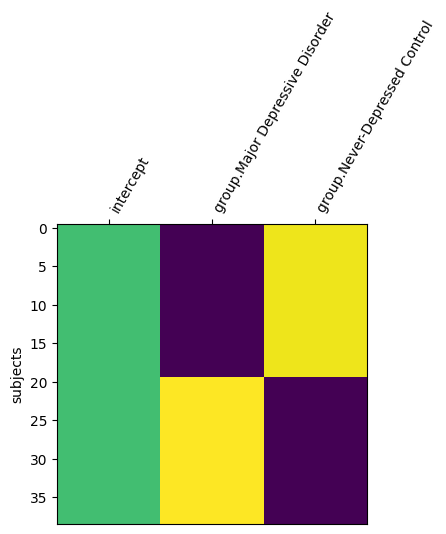

In [196]:
fig, ax = plt.subplots(figsize=(4, 0.1 * len(dataset_outputs[0].X)))
plot_design_matrix(dataset_outputs[0].X, axes=ax)
ax.set_ylabel("subjects")
plt.show()

# Group Statistical Models

## One Sample T-test

In [9]:
onesample_t = {
  "Name": "ds000171",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "control01",
      "control02",
      "control03",
      "control04",
      "control05",
      "control06",
      "control07",
      "control08",
      "control09",
      "control10",
      "control11",
      "control12",
      "control13",
      "control14",
      "control15",
      "control16",
      "control17",
      "control18",
      "control19",
      "control20",
      "mdd01",
      "mdd02",
      "mdd03",
      "mdd04",
      "mdd05",
      "mdd06",
      "mdd07",
      "mdd08",
      "mdd09",
      "mdd10",
      "mdd11",
      "mdd12",
      "mdd13",
      "mdd14",
      "mdd15",
      "mdd16",
      "mdd17",
      "mdd18",
      "mdd19"
    ],
    "task": [
      "music"
    ],
    "run": [
      1,
      2,
      3,
      4,
      5
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*",
          "rot_*",
          "cosine*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "musicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            0.5,
            0.5,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvnegmusic",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusicvsounds",
          "ConditionList": [
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusic",
          "ConditionList": [
            "trial_type.positive_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusic",
          "ConditionList": [
            "trial_type.negative_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "tones",
          "ConditionList": [
            "trial_type.tones"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "response",
          "ConditionList": [
            "trial_type.response"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        }
      ]
    },
    {
      "Level": "Subject",
      "Name": "subject_level",
      "GroupBy": [
        "subject",
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    },
    {
      "Level": "Dataset",
      "Name": "onesample_t", 
      "GroupBy": [
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    }
  ]
}
_, _, graph = get_bidstats_events(bids_inp, onesample_t, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

In [11]:
# root node for basic details
run_level_node = graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = graph.get_node(name="subject_level")

subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = graph.get_node(name="onesample_t")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

### Data Input

In this case, we are only performing a one sample t-test, i.e., voxelwise average of brain activity across all subjects' contrast maps. So there will only be a single transformation history index reflecting the input variables.

In [14]:
dataset_outputs[0].trans_hist[0].output.to_df(entities=True).head(10)

,subject,age,group,sex,suffix
0,control01,19,Never-Depressed Control,F,participants
1,control02,22,Never-Depressed Control,M,participants
2,control03,18,Never-Depressed Control,F,participants
3,control04,19,Never-Depressed Control,M,participants
4,control05,27,Never-Depressed Control,M,participants
5,control06,31,Never-Depressed Control,M,participants
6,control07,31,Never-Depressed Control,F,participants
7,control08,18,Never-Depressed Control,M,participants
8,control09,24,Never-Depressed Control,F,participants
9,control10,23,Never-Depressed Control,F,participants


### Model Matrix

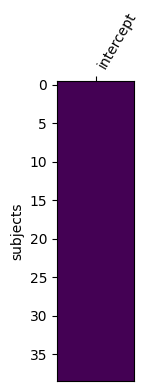

In [19]:
fig, ax = plt.subplots(figsize=(1, 0.1 * len(dataset_outputs[0].X)))
plot_design_matrix(dataset_outputs[0].X, axes=ax)
ax.set_ylabel("subjects")
plt.show()

## One Sample T-test w/ Covariate

In [20]:
onesample_tcov = {
  "Name": "ds000171",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "control01",
      "control02",
      "control03",
      "control04",
      "control05",
      "control06",
      "control07",
      "control08",
      "control09",
      "control10",
      "control11",
      "control12",
      "control13",
      "control14",
      "control15",
      "control16",
      "control17",
      "control18",
      "control19",
      "control20",
      "mdd01",
      "mdd02",
      "mdd03",
      "mdd04",
      "mdd05",
      "mdd06",
      "mdd07",
      "mdd08",
      "mdd09",
      "mdd10",
      "mdd11",
      "mdd12",
      "mdd13",
      "mdd14",
      "mdd15",
      "mdd16",
      "mdd17",
      "mdd18",
      "mdd19"
    ],
    "task": [
      "music"
    ],
    "run": [
      1,
      2,
      3,
      4,
      5
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*",
          "rot_*",
          "cosine*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "musicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            0.5,
            0.5,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvnegmusic",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusicvsounds",
          "ConditionList": [
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusic",
          "ConditionList": [
            "trial_type.positive_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusic",
          "ConditionList": [
            "trial_type.negative_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "tones",
          "ConditionList": [
            "trial_type.tones"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "response",
          "ConditionList": [
            "trial_type.response"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        }
      ]
    },
    {
      "Level": "Subject",
      "Name": "subject_level",
      "GroupBy": [
        "subject",
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    },
    {
      "Level": "Dataset",
      "Name": "onesample_tcov", 
      "GroupBy": [
        "contrast"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Demean",
            "Input": [
              "age"
            ],
            "Output": [
                "age_cent"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "age_cent"
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    }
  ]
}
_, _, graph = get_bidstats_events(bids_inp, onesample_tcov, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

In [22]:
# root node for basic details
run_level_node = graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = graph.get_node(name="subject_level")

subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = graph.get_node(name="onesample_tcov")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

### Data Input

In this case, we are transforming the `age` variable from the `participants.tsv` file that is at the BIDS root directory. We want to inspect to ensure that 1) the transformation took place and 2) worked correctly.



Step 1: Did the transformation take place? We only have a single transformation, so we can look at the last index [-1]

In [27]:
grp_df = dataset_outputs[0].trans_hist[1].output.to_df(entities=True)

grp_df.head(5)

,subject,age,age_cent,group,sex,suffix
0,control01,19,-12.435897,Never-Depressed Control,F,participants
1,control02,22,-9.435897,Never-Depressed Control,M,participants
2,control03,18,-13.435897,Never-Depressed Control,F,participants
3,control04,19,-12.435897,Never-Depressed Control,M,participants
4,control05,27,-4.435897,Never-Depressed Control,M,participants


Step 2: Did the transformation work correctly? We can plot the distribution of our `age` (original) and `age_center` (transformed/demeaned) variables.

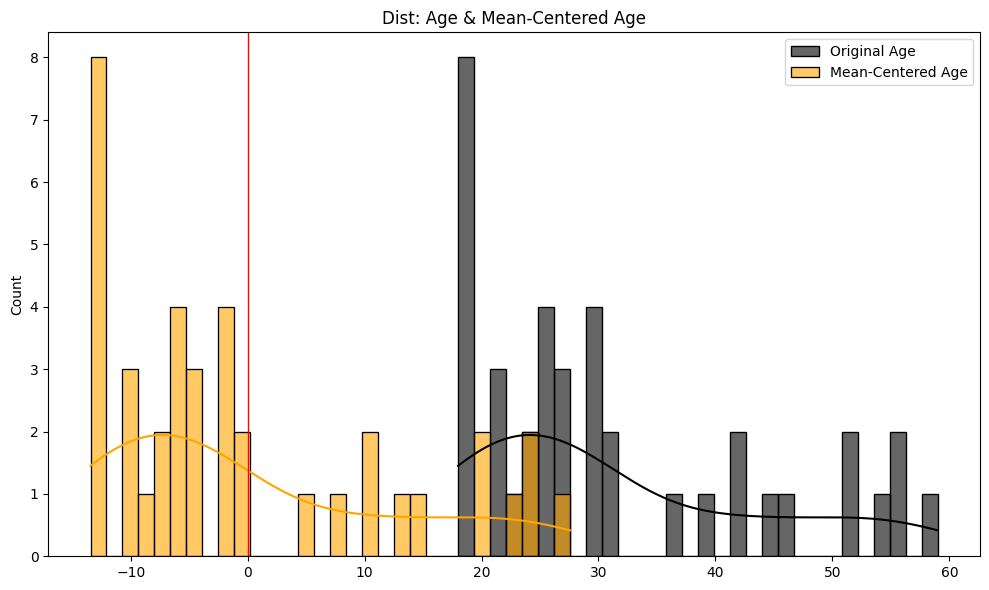

In [33]:

plt.figure(figsize=(10, 6))
sns.histplot(grp_df['age'], bins=30, color='black', kde=True, label='Original Age', alpha=0.6)
sns.histplot(grp_df['age_cent'], bins=30, color='orange', kde=True, label='Mean-Centered Age', alpha=0.6)
plt.axvline(0, color='red', linestyle='-', linewidth=1)
plt.title('Dist: Age & Mean-Centered Age')
plt.xlabel('')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

### Model Matrix

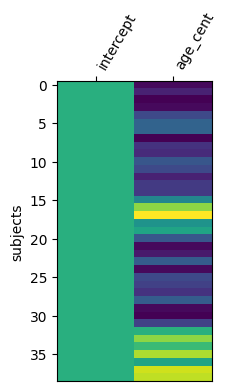

In [36]:
fig, ax = plt.subplots(figsize=(2, 0.1 * len(dataset_outputs[0].X)))
plot_design_matrix(dataset_outputs[0].X, axes=ax)
ax.set_ylabel("subjects")
plt.show()

## One Sample Paired T-test (runs) **[currently cannot fit]**

## Two-sample T-test

In [9]:
twosample_t = {
  "Name": "ds000171",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "control01",
      "control02",
      "control03",
      "control04",
      "control05",
      "control06",
      "control07",
      "control08",
      "control09",
      "control10",
      "control11",
      "control12",
      "control13",
      "control14",
      "control15",
      "control16",
      "control17",
      "control18",
      "control19",
      "control20",
      "mdd01",
      "mdd02",
      "mdd03",
      "mdd04",
      "mdd05",
      "mdd06",
      "mdd07",
      "mdd08",
      "mdd09",
      "mdd10",
      "mdd11",
      "mdd12",
      "mdd13",
      "mdd14",
      "mdd15",
      "mdd16",
      "mdd17",
      "mdd18",
      "mdd19"
    ],
    "task": [
      "music"
    ],
    "run": [
      1,
      2,
      3,
      4,
      5
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*",
          "rot_*",
          "cosine*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "musicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            0.5,
            0.5,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvnegmusic",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusicvsounds",
          "ConditionList": [
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusic",
          "ConditionList": [
            "trial_type.positive_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusic",
          "ConditionList": [
            "trial_type.negative_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "tones",
          "ConditionList": [
            "trial_type.tones"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "response",
          "ConditionList": [
            "trial_type.response"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        }
      ]
    },
    {
      "Level": "Subject",
      "Name": "subject_level",
      "GroupBy": [
        "subject",
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    },
    {
      "Level": "Dataset",
      "Name": "twosample_t", 
      "GroupBy": [
        "contrast"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "group"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "group.*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "control_vs_mdd",
          "ConditionList": [
            "group.control",
            "group.mdd"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "mddvcontrol", 
          "ConditionList": [
            "group.Major Depressive Disorder",
            "group.Never-Depressed Control"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        }
      ]
    }
  ]
}
_, _, graph = get_bidstats_events(bids_inp, twosample_t, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

In [10]:
# root node for basic details
run_level_node = graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = graph.get_node(name="subject_level")

subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = graph.get_node(name="twosample_t")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

#### Data Input

Everything here is similar to the one-sample t-test. We just now have a group transformation in the model specification file that "factorized" the group labels, or createas separate group columns with 1s/0s, creating a multi-column group data matrix

In [11]:
grp_df = dataset_outputs[0].trans_hist[1].output.to_df(entities=True)

grp_df.head(5)

,subject,age,group.Major Depressive Disorder,group.Never-Depressed Control,sex,suffix
0,control01,19,0.0,1.0,F,participants
1,control02,22,0.0,1.0,M,participants
2,control03,18,0.0,1.0,F,participants
3,control04,19,0.0,1.0,M,participants
4,control05,27,0.0,1.0,M,participants


#### Model Matrix

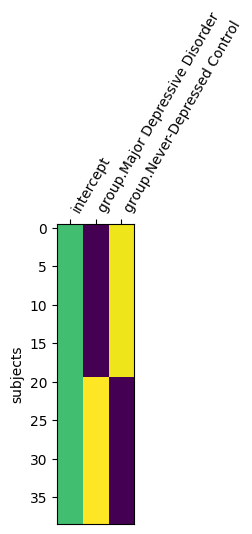

In [18]:
fig, ax = plt.subplots(figsize=(1, 0.1 * len(dataset_outputs[0].X)))
plot_design_matrix(dataset_outputs[0].X, axes=ax)
ax.set_ylabel("subjects")
plt.show()

## Two-sample T-test w/ Covariate

In [27]:
twosample_tcov = {
  "Name": "ds000171",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "control01",
      "control02",
      "control03",
      "control04",
      "control05",
      "control06",
      "control07",
      "control08",
      "control09",
      "control10",
      "control11",
      "control12",
      "control13",
      "control14",
      "control15",
      "control16",
      "control17",
      "control18",
      "control19",
      "control20",
      "mdd01",
      "mdd02",
      "mdd03",
      "mdd04",
      "mdd05",
      "mdd06",
      "mdd07",
      "mdd08",
      "mdd09",
      "mdd10",
      "mdd11",
      "mdd12",
      "mdd13",
      "mdd14",
      "mdd15",
      "mdd16",
      "mdd17",
      "mdd18",
      "mdd19"
    ],
    "task": [
      "music"
    ],
    "run": [
      1,
      2,
      3,
      4,
      5
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*",
          "rot_*",
          "cosine*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "musicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            0.5,
            0.5,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvnegmusic",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusicvsounds",
          "ConditionList": [
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusic",
          "ConditionList": [
            "trial_type.positive_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusic",
          "ConditionList": [
            "trial_type.negative_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "tones",
          "ConditionList": [
            "trial_type.tones"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "response",
          "ConditionList": [
            "trial_type.response"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        }
      ]
    },
    {
      "Level": "Subject",
      "Name": "subject_level",
      "GroupBy": [
        "subject",
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    },
    {
      "Level": "Dataset",
      "Name": "twosample_tcov", 
      "GroupBy": [
        "contrast"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Demean",
            "Input": [
              "age"
            ],
            "Output": [
                "age_cent"
            ]
          },
          {
            "Name": "Factor",
            "Input": [
              "group"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "group.*",
          "age_cent"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "agecent",
          "ConditionList": [
            "age_cent"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "mddvcontrol", 
          "ConditionList": [
            "group.Major Depressive Disorder",
            "group.Never-Depressed Control"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        }
      ]
    }
  ]
}
_, _, graph = get_bidstats_events(bids_inp, twosample_tcov, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

In [28]:
# root node for basic details
run_level_node = graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = graph.get_node(name="subject_level")

subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = graph.get_node(name="twosample_tcov")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

#### Data Input 

The data input will be similar to the one-sample t-test with our mean-cented age covariate, the only difference is now we have two transformations.

1. Mean center age
2. Factorize groups

In [29]:
grp_df = dataset_outputs[0].trans_hist[1].output.to_df(entities=True)
grp_df.head(3)

,subject,age,age_cent,group,sex,suffix
0,control01,19,-12.435897,Never-Depressed Control,F,participants
1,control02,22,-9.435897,Never-Depressed Control,M,participants
2,control03,18,-13.435897,Never-Depressed Control,F,participants


In [30]:
grp_df = dataset_outputs[0].trans_hist[2].output.to_df(entities=True)
grp_df.head(3)

,subject,age,age_cent,group.Major Depressive Disorder,group.Never-Depressed Control,sex,suffix
0,control01,19,-12.435897,0.0,1.0,F,participants
1,control02,22,-9.435897,0.0,1.0,M,participants
2,control03,18,-13.435897,0.0,1.0,F,participants


#### Model Matrix

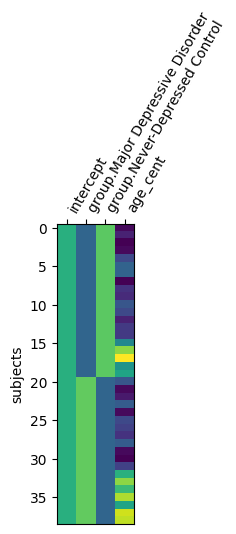

In [31]:
fig, ax = plt.subplots(figsize=(1, 0.1 * len(dataset_outputs[0].X)))
plot_design_matrix(dataset_outputs[0].X, axes=ax)
ax.set_ylabel("subjects")
plt.show()

## Two Group Continuous Interaction (coming)

## 2+ Group ANOVA

For an ANOVA, we need at least 3 groups. Unfortunately, the only grops provided in the data are sex & group. However, there is a wide age distribution. So, we can use pandas [qcut](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) function to create discrete groups that are [relatively] equal given the available data.

In [62]:
bids_layout = BIDSLayout(bids_inp,derivatives=False)
participants_file = bids_layout.get(suffix="participants", extension=".tsv")

In [63]:
participants_df = pd.read_csv(participants_file[0],sep='\t')
if 'age_group' not in participants_df.columns:
    participants_df['age_group'] = pd.qcut(participants_df['age'], 
                                           q=3, 
                                           labels=['younger', 'middle', 'older'])
    
    # save
    participants_df.to_csv(participants_file[0], sep='\t', index=False)
else:
    print("age_group already exists")

age_group already exists


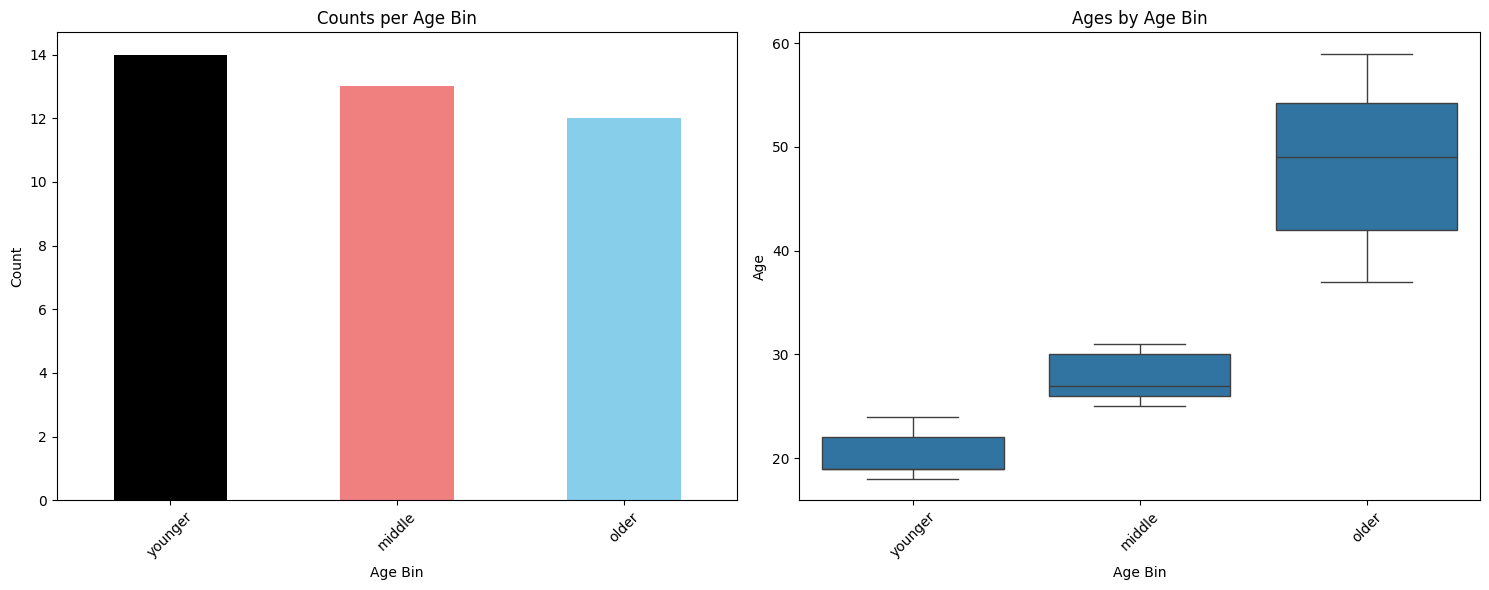

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# counts
group_counts = participants_df['age_group'].value_counts()
group_counts.plot(kind='bar', ax=ax1, color=['black', 'lightcoral', 'skyblue'])
ax1.set_title('Counts per Age Bin')
ax1.set_xlabel('Age Bin')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# hist dist
sns.boxplot(data=participants_df, x='age_group', y='age', ax=ax2)
ax2.set_title('Ages by Age Bin')
ax2.set_xlabel('Age Bin')
ax2.set_ylabel('Age')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [75]:
anova_3grp = {
  "Name": "ds000171",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "control01",
      "control02",
      "control03",
      "control04",
      "control05",
      "control06",
      "control07",
      "control08",
      "control09",
      "control10",
      "control11",
      "control12",
      "control13",
      "control14",
      "control15",
      "control16",
      "control17",
      "control18",
      "control19",
      "control20",
      "mdd01",
      "mdd02",
      "mdd03",
      "mdd04",
      "mdd05",
      "mdd06",
      "mdd07",
      "mdd08",
      "mdd09",
      "mdd10",
      "mdd11",
      "mdd12",
      "mdd13",
      "mdd14",
      "mdd15",
      "mdd16",
      "mdd17",
      "mdd18",
      "mdd19"
    ],
    "task": [
      "music"
    ],
    "run": [
      1,
      2,
      3,
      4,
      5
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*",
          "rot_*",
          "cosine*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "musicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            0.5,
            0.5,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvnegmusic",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusicvsounds",
          "ConditionList": [
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusic",
          "ConditionList": [
            "trial_type.positive_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusic",
          "ConditionList": [
            "trial_type.negative_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "tones",
          "ConditionList": [
            "trial_type.tones"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "response",
          "ConditionList": [
            "trial_type.response"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        }
      ]
    },
    {
      "Level": "Subject",
      "Name": "subject_level",
      "GroupBy": [
        "subject",
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    },
    {
      "Level": "Dataset",
      "Name": "anova_3grp", 
      "GroupBy": [
        "contrast"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "age_group"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "age_group.*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "oldervyounger", 
          "ConditionList": [
            "group.Major Depressive Disorder",
            "group.Never-Depressed Control"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "oldervmiddle", 
          "ConditionList": [
            "group.Major Depressive Disorder",
            "group.Never-Depressed Control"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "middlevyounger", 
          "ConditionList": [
            "group.Major Depressive Disorder",
            "group.Never-Depressed Control"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        }
      ]
    }
  ]
}
_, _, graph = get_bidstats_events(bids_inp, anova_3grp, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)

In [76]:
# root node for basic details
run_level_node = graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = graph.get_node(name="subject_level")

subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = graph.get_node(name="anova_3grp")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

#### Data Input

Since the transformations are nearly identical to the two-sample t-test with a covariate except we have three groups now, we will only look at the last transformation.

In [77]:
grp_df = dataset_outputs[0].trans_hist[-1].output.to_df(entities=True)
grp_df.head(3)

,subject,age,age_group.middle,age_group.older,age_group.younger,group,sex,suffix
0,control01,19,0.0,0.0,1.0,Never-Depressed Control,F,participants
1,control02,22,0.0,0.0,1.0,Never-Depressed Control,M,participants
2,control03,18,0.0,0.0,1.0,Never-Depressed Control,F,participants


#### Model Matrix

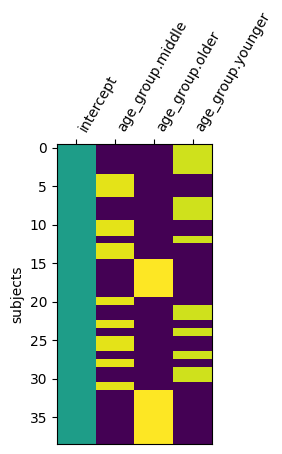

In [79]:
fig, ax = plt.subplots(figsize=(2, 0.1 * len(dataset_outputs[0].X)))
plot_design_matrix(dataset_outputs[0].X, axes=ax)
ax.set_ylabel("subjects")
plt.show()